Notes for Chapter 4: https://d2l.ai/chapter_linear-classification/index.html

### 4.1. Softmax regression
 (no code)

### 4.2. Image Classification Dataset

In [1]:
%matplotlib inline
import time
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()

In [2]:
class FashionMNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=128, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
data = FashionMNIST(resize=(32, 32))
len(data.train[0]), len(data.val[0])

(60000, 10000)

In [4]:
data.train[0][0].shape

(28, 28)

In [5]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [6]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(
        self.batch_size).map(resize_fn).shuffle(shuffle_buf)

In [7]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(128, 32, 32, 1) <dtype: 'float32'> (128,) <dtype: 'int32'>


In [8]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'0.74 sec'

#### 4.2.3. Visualization

In [9]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

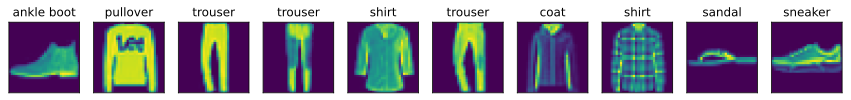

In [10]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=10, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(tf.squeeze(X), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [11]:
data.val[0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [12]:
print(text_labels)

None


### 4.3. Base Classification

In [13]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [14]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [15]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

#### 4.3.2 Accuracy

In [16]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    preds = tf.cast(tf.argmax(Y_hat, axis=1), Y.dtype)
    compare = tf.cast(preds == tf.reshape(Y, -1), tf.float32)
    return tf.reduce_mean(compare) if averaged else compare

#### 4.4. Softmax regression from scratch

In [17]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [18]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [19]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [20]:
X = tf.random.uniform((2, 5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.2468494 , 0.15366293, 0.16818564, 0.2566111 , 0.17469092],
        [0.1777898 , 0.18873064, 0.1983035 , 0.2038059 , 0.23137018]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99999994, 1.        ], dtype=float32)>)

#### 4.4.2. The model

In [21]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = tf.random.normal((num_inputs, num_outputs), 0, sigma)
        self.b = tf.zeros(num_outputs)
        self.W = tf.Variable(self.W)
        self.b = tf.Variable(self.b)

In [22]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = tf.reshape(X, (-1, self.W.shape[0]))
    return softmax(tf.matmul(X, self.W) + self.b)

### 4.4.3. Cross-Entropy Loss

In [23]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [24]:
def cross_entropy(y_hat, y):
    return -tf.reduce_mean(tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4978662>

In [25]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

### 4.4.4. Training

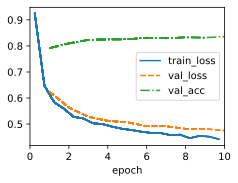

In [26]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 4.4.5. Prediction

In [27]:
X, y = next(iter(data.val_dataloader()))
preds = tf.argmax(model(X), axis=1)
preds.shape

TensorShape([256])

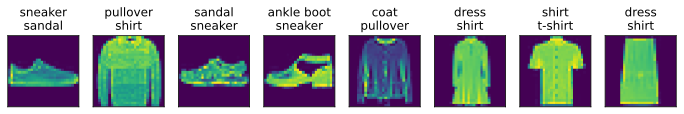

In [28]:
wrong = tf.cast(preds, y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

In [29]:
preds

<tf.Tensor: shape=(38,), dtype=int64, numpy=
array([5, 6, 7, 7, 2, 6, 0, 6, 6, 6, 2, 6, 0, 4, 7, 6, 6, 6, 4, 4, 6, 3,
       6, 2, 3, 6, 8, 4, 3, 6, 2, 4, 6, 2, 6, 4, 4, 4], dtype=int64)>

### 4.5. Concise implementation of Softmax Regression

In [30]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [31]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        self.net.add(tf.keras.layers.Flatten())
        self.net.add(tf.keras.layers.Dense(num_outputs))

    def forward(self, X):
        return self.net(X)

In [32]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = tf.reshape(Y, (-1,))
    fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return fn(Y, Y_hat)

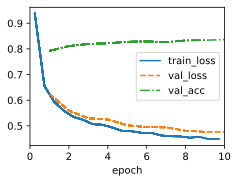

In [33]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 4.6. Generalization in Classification

### 4.7. Environment and Distribution Shift